In [27]:
# Basic exploratory data analysis of the Ames House Price Dataset
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

# Read in the data
house = pd.read_csv('./train_cleaned.csv')
house.shape

(1460, 78)

In [28]:
# Out of interest - how big is the test set?
house_test = pd.read_csv('../rawData/test.csv')
house_test.shape
#1460+1459=2919

(1459, 80)

In [29]:
# follow advice from http://jse.amstat.org/v19n3/decock.pdf to remove outliers
#house = house[house['GrLivArea']<=4000]
nrows, ncols = house.shape

# Define mean sale price
mu_abs = house['SalePrice'].mean()
nrows

1460

In [30]:
# This is the cleaned dataset so
house.columns[house.isna().any()]

Index([], dtype='object')

In [31]:
# Does price vary over time?
house['SaleDate'] = house[['YrSold', 'MoSold']].apply(lambda x: datetime.date(x[0], x[1], 1), axis = 1)
df = house.groupby('SaleDate')['SalePrice'].agg(['mean', 'count'])
lin = LinearRegression()
x = np.arange((len(df.index))).reshape(-1, 1)
lin.fit(x, df['mean'])
df['trend'] = lin.predict(x)
print(f"Trend is from {df['trend'][0]:.2f} to {df['trend'][-1]:.2f}, a {df['trend'][-1]/df['trend'][0]-1:.2%} change.")

fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig1.add_trace(go.Scatter(x=df.index, y=df['mean'], name='Avg Sale Price'))
fig1.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Price Trend', line={'color': 'blue', 'dash': 'dot'}))
fig1.add_trace(go.Bar(x=df.index, y=df['count'], name='No. Sales', opacity=0.75), secondary_y=True,)
fig1.update_layout(
    title='Monthly Avg Sale Prices',
    xaxis_title='',
    yaxis_title=''
)
# So there's seasonality in the number of sales and a downtrend in average price

Trend is from 190377.55 to 172378.11, a -9.45% change.


In [32]:
# What about price per square foot?
house['SalePxSqFt'] = house['SalePrice'] / house['GrLivArea']
mu_sqft = house['SalePxSqFt'].mean()
df = house.groupby('SaleDate')['SalePxSqFt'].agg(['mean', 'count'])
lin = LinearRegression()
x = np.arange((len(df.index))).reshape(-1, 1)
lin.fit(x, df['mean'])
df['trend'] = lin.predict(x)
print(f"Trend is from {df['trend'][0]:.2f} to {df['trend'][-1]:.2f}, a {df['trend'][-1]/df['trend'][0]-1:.2%} change.")

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=df.index, y=df['mean'], name='Avg Sale Price'))
fig2.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Price Trend', line={'color': 'blue', 'dash': 'dot'}))
fig2.add_trace(go.Bar(x=df.index, y=df['count'], name='No. Sales', opacity=0.75), secondary_y=True,)
fig2.update_layout(
    title='Monthly Avg Px per Sq Ft',
    xaxis_title='',
    yaxis_title=''
)
# Px per square foot is basically constant.  The reason outright prices fell is because there were fewer big
# houses selling.

Trend is from 121.53 to 119.20, a -1.92% change.


In [33]:
# Check for possible duplicate rows
house['IdCheck'] = house[['SaleDate', 'SalePrice', 'GrLivArea']].apply(lambda x: str(x[0]) + str(x[1]) + str(x[2]), axis = 1)
house['IdCheck'].value_counts().max()
# we're good

1

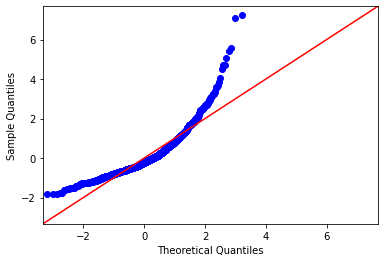

In [34]:
# Is the target normally distributed?
import statsmodels.api as sm
import matplotlib.pyplot as plt

norm_px = (house['SalePrice'] - house['SalePrice'].mean()) / house['SalePrice'].std()
sm.qqplot(norm_px, line ='45')
plt.show()
# No!

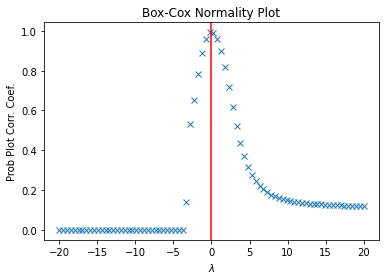

lambda = -0.08


In [35]:
from scipy import stats
# shift norm_px to the right to avoid negative values
norm_px_shft = (norm_px - norm_px.min() + 0.01)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
prob = stats.boxcox_normplot(house['SalePrice'], -20, 20, plot=ax3)

_, maxlog = stats.boxcox(house['SalePrice'])
ax3.axvline(maxlog, color='r')
plt.show()
print(f'lambda = {maxlog:.2f}')

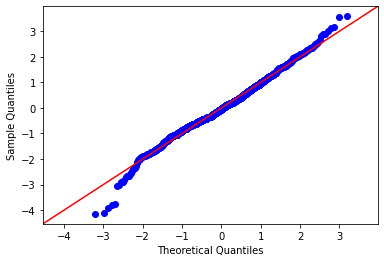

In [36]:
bc_prices = (house['SalePrice']**maxlog - 1) / maxlog
norm_bc_prices = (bc_prices - bc_prices.mean()) / bc_prices.std()
sm.qqplot(norm_bc_prices, line ='45')
plt.show()

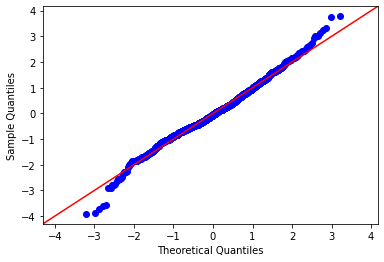

In [37]:
# Frankly, log works almost as well and it's fewer things to worry about
bc_prices = np.log(house['SalePrice'])
norm_bc_prices = (bc_prices - bc_prices.mean()) / bc_prices.std()
sm.qqplot(norm_bc_prices, line ='45')
plt.show()

In [38]:
# the Continuous Variables
contin = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal']

In [39]:
contin_plt = house[contin].drop(['LotFrontage', 'LotArea', 'MiscVal'], axis=1)
fig3 = px.box(pd.melt(contin_plt), x="variable", y="value")
fig3.update_layout(
    title='Continuous Variables',
    xaxis_title='',
    yaxis_title=''
)
# It's only worth using variables that have enough variation themselves
# GrLivArea is already an obvious first choice.  BsmtFinSF1 and TotalBsmtSF look like they add information,
# as does GarageArea
# 1stFlrSF etc. presumably are already covered by GrLivArea
# The variables to the right can either be converted to categorical (has pool / doesn't have pool)
# or ignored

In [40]:
# How correlated are these variables?
# First let's standardize to mean 0, std 1
house_s = house.copy()
for col in contin:
    house_s[col] = (house[col] - house[col].mean()) / house[col].std()
contin_corr = house_s[contin].T @ house_s[contin] / (nrows-1)

heat = go.Heatmap(z=contin_corr,
                  x=contin_corr.index,
                  y=contin_corr.index,
                  xgap=1, ygap=1,
                  colorscale='RdBu',
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  #hovertext =hovertext,
                  #hoverinfo='text'
)
layout = go.Layout(title_text='Correlations of Contin Variables', title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed'
                  )
   
fig4=go.Figure(data=[heat], layout=layout)        
fig4.show()

In [41]:
# the Discrete Variables
disc = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

In [42]:
disc_cts_plt = house[disc].drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'], axis=1)
fig5 = px.box(pd.melt(disc_cts_plt), x="variable", y="value")
fig5.update_layout(
    title='Discrete Counting Variables',
    xaxis_title='',
    yaxis_title=''
)
# MoSold we covered already above
# GarageCars is an alternate to GarageArea above - pick 1
# However, GarageCars == 0 is a big problem so we need to make sure that's being picked up
# same applies I think to Bsmt stats here - either pick it up from the area stats or here, not both
# FullBath, HalfBath, BedroomAbvGr look interesting.  Suspect TotRmsAbvGrd is the sum of others + const.
# Kind of amazing spe houses had 0 FullBath?
# Kitchen adds no value, everybody has 1
# Fireplaces should be categorical yes/no

In [43]:
disc_yrs_plt = house[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']]
fig6 = px.box(pd.melt(disc_yrs_plt), x="variable", y="value")
fig6.update_layout(
    title='Discrete Year Variables',
    xaxis_title='',
    yaxis_title=''
)
# First two look sensible, GarageYrBlt probably correlates far too much with YearBuilt
# YrSold discussed already

In [44]:
# How correlated are these variables?
# First let's standardize to mean 0, std 1

for col in disc:
    house_s[col] = (house[col] - house[col].mean()) / house[col].std()
disc_corr = house_s[disc].T @ house_s[disc] / (nrows-1)

heat = go.Heatmap(z=disc_corr,
                  x=disc_corr.index,
                  y=disc_corr.index,
                  xgap=1, ygap=1,
                  colorscale='RdBu',
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  #hovertext =hovertext,
                  #hoverinfo='text'
)
layout = go.Layout(title_text='Correlations of Discrete Variables', title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed'
                  )
   
fig7=go.Figure(data=[heat], layout=layout)        
fig7.show()

In [45]:
# the Nominal Variables
nom = ['Id', 'MSSubClass', 'MSZoning', 'Street',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
       'SaleType', 'SaleCondition']

# let's ignore Id (which duplicates the dataframe index)
nom.remove('Id')

nom_summary = pd.DataFrame(index=nom, columns=['Type', 'Levels', 'MaxCount', 'MinCount', 'Missing'])

for col in nom:
    c = house[col].value_counts()
    nom_summary.loc[col, :] = [house[col].dtype, len(c), max(c), min(c), nrows - c.sum()]

# print(nom_summary.sort_values('MaxCount'))
# print('-'*54)
# Obviously ditch the first two (MiscFeature and Alley)
# It probably makes sense to throw out variables if > 50% of obs fall into one category

# This df will look at the variation in avg sale price using each variable as a groupby
nom_pxImpact = pd.DataFrame(index=nom, columns=['Levels', 'Min', 'Max', 'WVar', 'Missing'])
# I want to add linearity metrics, but that's tomorrow's task

# Let's weight the std of each level in the group by the number of observations in the level
def wgt_var(x, weights):
    return (np.dot(weights, (x - mu_sqft) ** 2)/weights.sum())
    
for col in nom:
    # should I look at absolute sale price or per sq ft?  TBD.  Going with per sq ft for now
    df = house.groupby(col)['SalePxSqFt'].agg(['mean', 'count']).sort_values('mean')
    # print(df)
    nom_pxImpact.loc[col, :] = [df.shape[0], df['mean'].min(), df['mean'].max(), 
                                wgt_var(df['mean'], df['count']/nrows), nrows - df['count'].sum()]

nom_pxImpact.sort_values('WVar', ascending=False)

,Levels,Min,Max,WVar,Missing
Neighborhood,25,84.7552,165.402,381.989,0
MSSubClass,15,82.5976,151.776,358.027,0
HouseStyle,8,74.4221,141.663,230.624,0
Foundation,6,84.5402,134.236,194.162,0
GarageType,7,87.0525,129.949,152.282,0
Exterior2nd,16,76.4192,174.699,151.181,0
Exterior1st,15,60.0962,161.33,147.261,0
SaleCondition,6,95.2015,153.676,125.383,0
MasVnrType,4,101.287,151.611,121.504,0
SaleType,9,101.924,163.795,115.481,0


In [46]:
# Box plot of neighborhood vs log sale price
house['logSalePrice'] = np.log(house['SalePrice'])
df1 = house[['Neighborhood', 'SalePrice']].groupby('Neighborhood').mean().sort_values('SalePrice', ascending=False)
house['NhAvg'] = house['Neighborhood'].apply(lambda x: df1.loc[x, 'SalePrice'])
def px_group(x):
    if x > 220000: return 1
    elif x > 170000: return 2
    elif x > 130000: return 3
    else: return 4
house['pxgroup'] = house['Neighborhood'].apply(lambda x: px_group(df1.loc[x, 'SalePrice']))

df = house[['Neighborhood', 'SalePrice', 'NhAvg', 'pxgroup']].sort_values('NhAvg', ascending=False)
fig8 = px.box(df, x='Neighborhood', y='SalePrice') #, color='pxgroup')
m = house['SalePrice'].mean()
fig8.update_layout(
    shapes=[
    dict(
      type= 'line',
      name = 'Avg',
      yref= 'y', y0= m, y1= m,
      xref= 'paper', x0= 0, x1= 1,
      line=dict(
                    color="Red",
                    width=2,
                    dash="dot",
                )
    )],
    annotations=[
        dict(
            x='IDOTRR',
            y= 200010,
            xref="x",
            yref="y",
            text="Avg",
            font=dict(
                color="Red",
                size=12
            ),
            showarrow=False
            )],
    showlegend = False,
    title='Distribution of Sale Price by Neighborhood',
    xaxis_tickangle=45,
    xaxis_title='')
fig8.show()

In [47]:
# Same but with price per square foot
house['logSalePrice'] = np.log(house['SalePrice'])
df1 = house[['Neighborhood', 'SalePxSqFt']].groupby('Neighborhood').mean().sort_values('SalePxSqFt', ascending=False)
house['NhAvgSqFt'] = house['Neighborhood'].apply(lambda x: df1.loc[x, 'SalePxSqFt'])

df = house[['Neighborhood', 'SalePxSqFt', 'NhAvgSqFt']].sort_values('NhAvgSqFt', ascending=False)
fig9 = px.box(df, x='Neighborhood', y='SalePxSqFt') #, color='pxgroup')
m = house['SalePxSqFt'].mean()
fig9.update_layout(
    shapes=[
    dict(
      type= 'line',
      name = 'Avg',
      yref= 'y', y0= m, y1= m,
      xref= 'paper', x0= 0, x1= 1,
      line=dict(
                    color="Red",
                    width=2,
                    dash="dot",
                )
    )],
    annotations=[
        dict(
            x='SWISU',
            y= m + 6,
            xref="x",
            yref="y",
            text="Avg",
            font=dict(
                color="Red",
                size=12
            ),
            showarrow=False
            )],
    showlegend = False,
    title='Distribution of Sale Price / sq ft by Neighborhood',
    xaxis_tickangle=45,
    xaxis_title='')
fig9.show()

In [48]:
house['builtPct'] = house['GrLivArea'] / house['LotArea']
df = house.loc[house['builtPct']<=.15, ['builtPct', 'NhAvgSqFt', 'Neighborhood']]\
    .groupby('Neighborhood').agg({'builtPct': 'count', 'NhAvgSqFt': 'first'}).sort_values('NhAvgSqFt', ascending=False)
print(df)

              builtPct   NhAvgSqFt
Neighborhood                      
StoneBr              4  165.402275
NridgHt             18  164.578057
Veenker              8  154.980914
Somerst             11  141.335966
Timber              23  139.766483
CollgCr             63  136.783680
NoRidge              7  132.271687
Mitchel             35  126.017449
ClearCr             18  124.242989
Crawfor             26  120.254826
SawyerW             23  119.704424
Gilbert             30  119.114931
Sawyer              62  117.856163
NAmes              165  116.089385
NWAmes              39  111.848349
BrkSide             24  105.966809
Edwards             63  101.832958
OldTown             34   91.427282
IDOTRR              18   89.136043
SWISU                3   84.755233


In [49]:
# the Ordinal Variables
ords = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'OverallQual',
         'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
         'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
         'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
         'GarageQual', 'GarageCond', 'PavedDrive', 'Fence']

ord_summary = pd.DataFrame(index=ords, columns=['Type', 'Levels', 'MaxCount', 'MinCount', 'Missing'])

for col in ords:
    c = house[col].value_counts()
    ord_summary.loc[col, :] = [house[col].dtype, len(c), max(c), min(c), nrows - c.sum()]

ord_summary.sort_values('MaxCount')
# So let's ditch the first three

ord_pxImpact = pd.DataFrame(index=ords, columns=['Levels', 'Min', 'Max', 'WVar', 'Missing'])

for col in ords:
    df = house.groupby(col)['SalePxSqFt'].agg(['mean', 'count']).sort_values('mean')
    print(df)
    ord_pxImpact.loc[col, :] = [df.shape[0], df['mean'].min(), df['mean'].max(), 
                                wgt_var(df['mean'], df['count']/nrows), nrows - df['count'].sum()]

ord_pxImpact.sort_values('WVar', ascending=False)

                mean  count
LotShape                   
4         116.147306    925
1         117.737859     10
3         127.997560    484
2         133.462121     41
                   mean  count
LandContour                   
2             95.391753     63
1            120.670077   1311
4            133.013983     36
3            140.794952     50
                 mean  count
Utilities                   
2          102.306548      1
4          120.585398   1459
                 mean  count
LandSlope                   
3          120.484175   1382
2          121.195893     65
1          126.887671     13
                   mean  count
OverallQual                   
3             79.895426     20
1             92.571273      2
2             95.183628      3
4            102.401838    116
5            112.746779    397
6            114.346688    374
7            124.494470    319
8            144.511059    168
10           160.423437     18
9            178.693921     43
             

,Levels,Min,Max,WVar,Missing
BsmtQual,5,85.8403,162.372,286.183,0
OverallQual,10,79.8954,178.694,266.252,0
ExterQual,4,82.7537,170.629,233.454,0
BsmtFinType1,7,85.8403,142.177,230.784,0
KitchenQual,4,90.1988,160.131,230.572,0
BsmtExposure,5,86.4337,147.574,180.012,0
GarageFinish,4,93.8643,136.123,174.612,0
HeatingQC,5,97.4797,131.688,133.576,0
OverallCond,9,67.4779,127.503,119.26,0
BsmtCond,5,64.8439,132.587,83.7034,0


In [50]:
# In-depth look at Quality
df = house.groupby('OverallQual')['SalePrice'].agg(['mean', 'count'])
x = np.arange(1, 11).reshape(-1, 1)
lin.fit(x, np.log(df['mean']))
df['trend'] = np.exp(lin.predict(x))
print(np.exp(lin.coef_))

fig10 = make_subplots(specs=[[{"secondary_y": True}]])
fig10.add_trace(go.Scatter(x=df.index, y=df['mean'], name='Avg Sale Price'))
fig10.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Regression', opacity=0.75, mode='lines', line={'color': 'blue', 'dash': 'dot'}))
fig10.add_trace(go.Bar(x=df.index, y=df['count'], name='No. Sales', opacity=0.75), secondary_y=True,)
fig10.update_layout(
    title='Mean Sale Prices vs. Overall Quality Score',
    xaxis_title='Overall Quality',
    xaxis_dtick=1,
    legend = dict(x = .7, y = .7),
)
fig10.update_yaxes(title='Number of Sales', tickformat='.0f', showgrid = False, secondary_y=True)
fig10.update_yaxes(title='Mean Sale Price', type="log", tickformat='$,.0f', showgrid = True, secondary_y=False)

[1.28285989]


In [51]:
# How does sale price correlate with sq ft and does adding a quadratic term help?
x = house['GrLivArea'].values.reshape(-1, 1)
x_2 = x ** 2
#x_3 = x ** 3
#x_4 = x ** 4
X = np.concatenate([x, x_2], axis=1)
lin.fit(X, house['SalePrice'])
Y = lin.predict(X)
fig11 = go.Figure()
fig11.add_trace(go.Scatter(x=house['GrLivArea'], y=house['SalePrice'], name='SalePx', mode='markers', opacity=0.75))
fig11.add_trace(go.Scatter(x=house['GrLivArea'], y=Y, name='Fit', mode='markers'))
fig11.update_layout(
    title='Sale Price vs. Sq Ft above Grade',
    xaxis_title='Sq Ft',
    yaxis_title='Sale Price'
)
# The quadratic term didn't help

In [52]:
# A/c, Fireplace, Basement Full Baths and Garage N Cars
# The first two are ln mean-value encoded in my regression:
ac = house.groupby('CentralAir')['logSalePrice'].agg(['mean', 'count'])
ac_coef = .31425
print(ac)
print(np.exp((ac.loc['Y', 'mean'] - ac.loc['N', 'mean']) * ac_coef))

fire = house.groupby('FireplaceQu')['logSalePrice'].agg(['mean', 'count'])
fire_coef = .14212
print(fire)
print(np.exp(((fire.loc[4, 'mean']+fire.loc[3, 'mean'])/2 - fire.loc[0, 'mean']) * fire_coef))

# THe other two are treated as numeric in my regression:
bsmt = house.groupby('BsmtFullBath')['logSalePrice'].agg(['mean', 'count'])
bsmt_coef = .05961
print(bsmt)
print(np.exp(bsmt_coef))

cars = house.groupby('GarageCars')['logSalePrice'].agg(['mean', 'count'])
cars_coef = .08673
print(cars)
print(np.exp(cars_coef))

                 mean  count
CentralAir                  
N           11.491858     95
Y           12.061090   1365
1.1958787058022242
                  mean  count
FireplaceQu                  
0            11.808907    690
1            11.738817     20
2            12.008509     33
3            12.186416    313
4            12.256533    380
5            12.670019     24
1.060387103399592
                   mean  count
BsmtFullBath                  
0             11.943810    856
1             12.136303    588
2             12.198107     15
3             12.095141      1
1.0614225110343796
                 mean  count
GarageCars                  
0           11.491874     81
1           11.731868    369
2           12.083613    824
3           12.583590    181
4           12.137198      5
1.0906021773743593
